In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

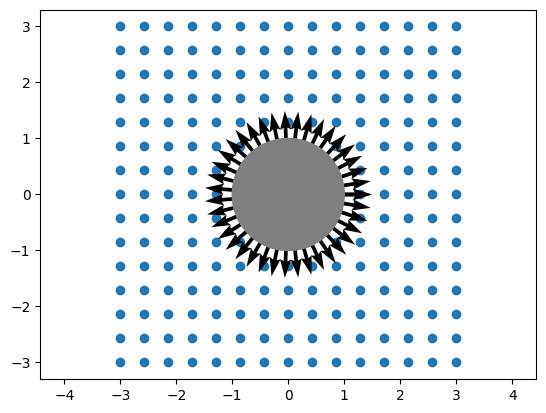

In [ ]:
# make x y grid
x_range = np.linspace(-3, 3, 15)
y_range = np.linspace(-3, 3, 15)

xx, yy = np.meshgrid(x_range, y_range)
cylinder_radius = 1.0

norm_of_grid = np.sqrt(xx ** 2 + yy ** 2)

mask = norm_of_grid <= cylinder_radius
xx = np.ma.masked_array(xx, mask)
yy = np.ma.masked_array(yy, mask)

# make cylinder points
circle_points = 40
thetas = np.linspace(0, 2*np.pi, circle_points)
x_circle = cylinder_radius * np.cos(thetas)
y_circle = cylinder_radius * np.sin(thetas)
dx_dtheta = cylinder_radius * np.sin(thetas)
dy_dtheta = -cylinder_radius * np.cos(thetas)
normal_vectors = np.array([(-dy_dtheta[i], dx_dtheta[i]) for i in range(circle_points)])

norms = np.linalg.norm(normal_vectors, axis=1)
normal_vectors = normal_vectors / norms[:, np.newaxis]

fig, ax = plt.subplots(1)

ax.scatter(xx, yy)
ax.quiver(x_circle, y_circle, normal_vectors[:, 0], normal_vectors[:, 1])
ax.axis("equal")

Drawing_colored_circle = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
ax.set_aspect(1)
ax.add_patch(Drawing_colored_circle)

plt.show()

In [ ]:
grid_xys = torch.stack((torch.tensor(xx.compressed(), dtype=torch.float32).flatten(), torch.tensor(yy.compressed(), dtype=torch.float32).flatten()), 1)
print(grid_xys.size())

circle_xys = torch.stack((torch.tensor(x_circle, dtype=torch.float32), torch.tensor(y_circle, dtype=torch.float32)), 1)
print(circle_xys.size())

all_xys = torch.vstack((grid_xys, circle_xys)).requires_grad_(True)
print(all_xys.size())

cylinder_normals = torch.tensor(normal_vectors, dtype=torch.float32)
print(cylinder_normals.size())

# identify indices of boundaries
inlet_indices = np.where(grid_xys[: , 0] == -3.0)
inlet_indices = inlet_indices[0][1:-1]
print(inlet_indices)

outlet_indices = np.where(grid_xys[:, 0] == 3.0)
outlet_indices = outlet_indices[0][1:-1]
print(outlet_indices)

lower_wall_indices = np.where(grid_xys[:, 1] == -3.0)
lower_wall_indices = lower_wall_indices[0]
print(lower_wall_indices)

upper_wall_indices = np.where(grid_xys[:, 1] == 3.0)
upper_wall_indices = upper_wall_indices[0]
print(upper_wall_indices)

torch.Size([204, 2])
torch.Size([40, 2])
torch.Size([244, 2])
torch.Size([40, 2])
[ 15  30  45  60  75  87  97 107 117 129 144 159 174]
[ 29  44  59  74  86  96 106 116 128 143 158 173 188]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[189 190 191 192 193 194 195 196 197 198 199 200 201 202 203]


In [ ]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )

    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x

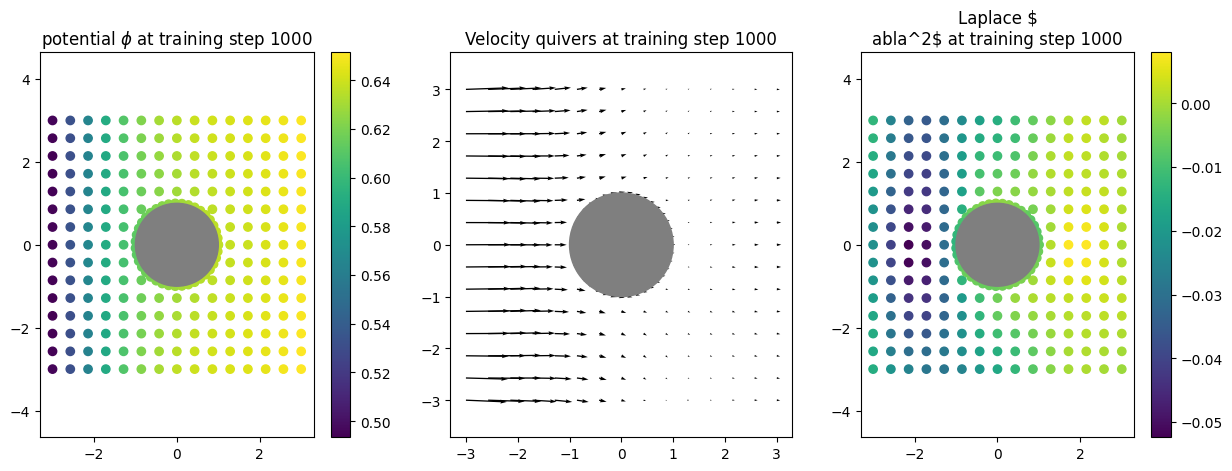

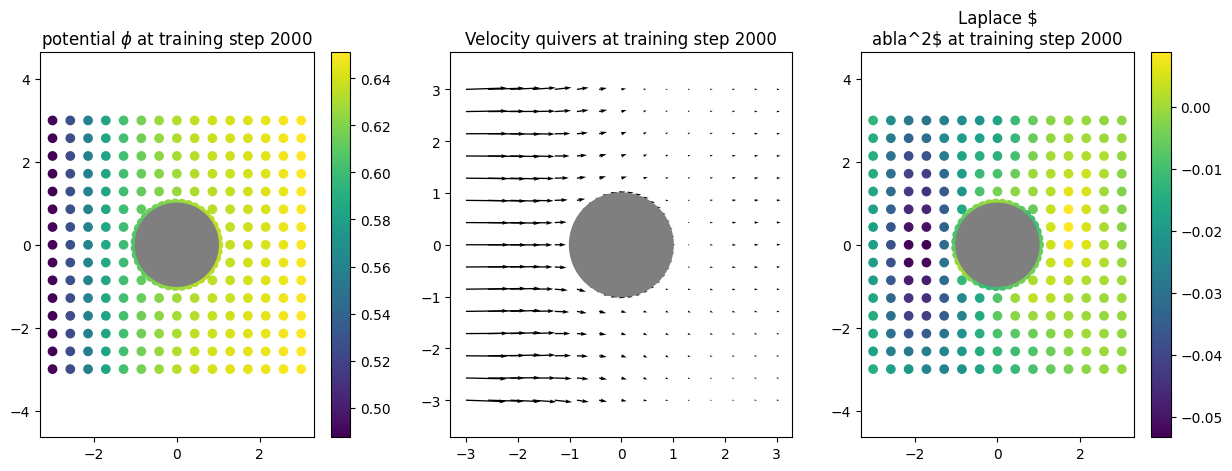

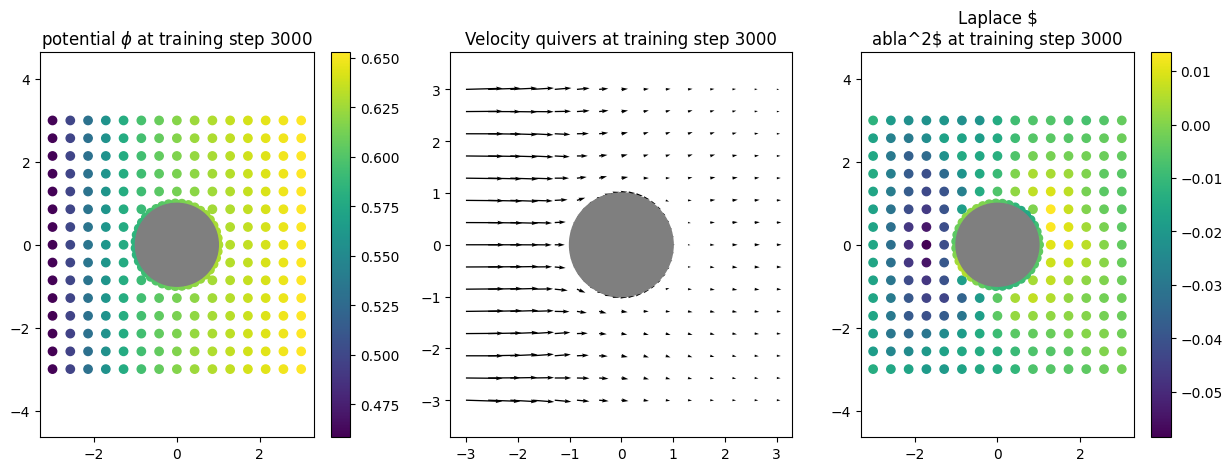

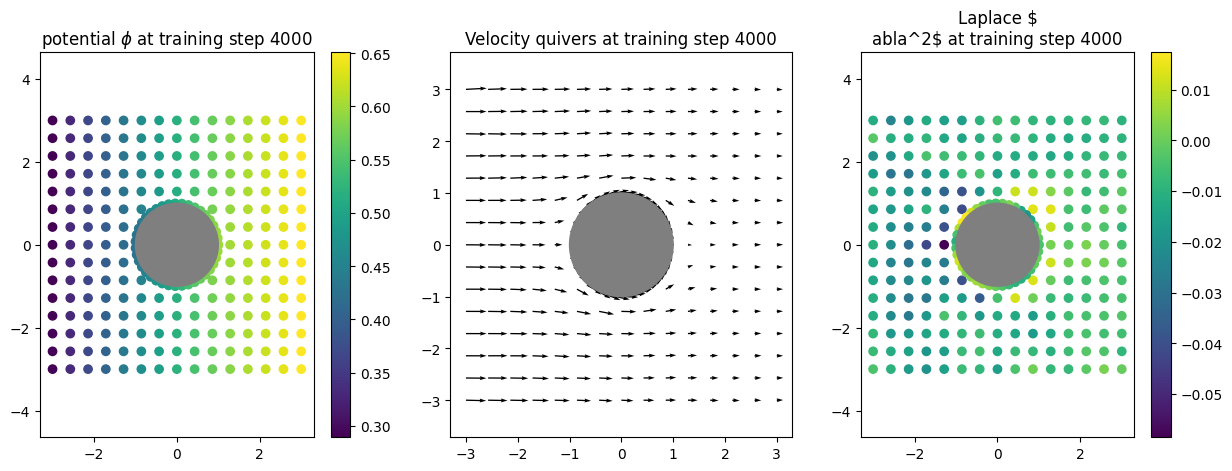

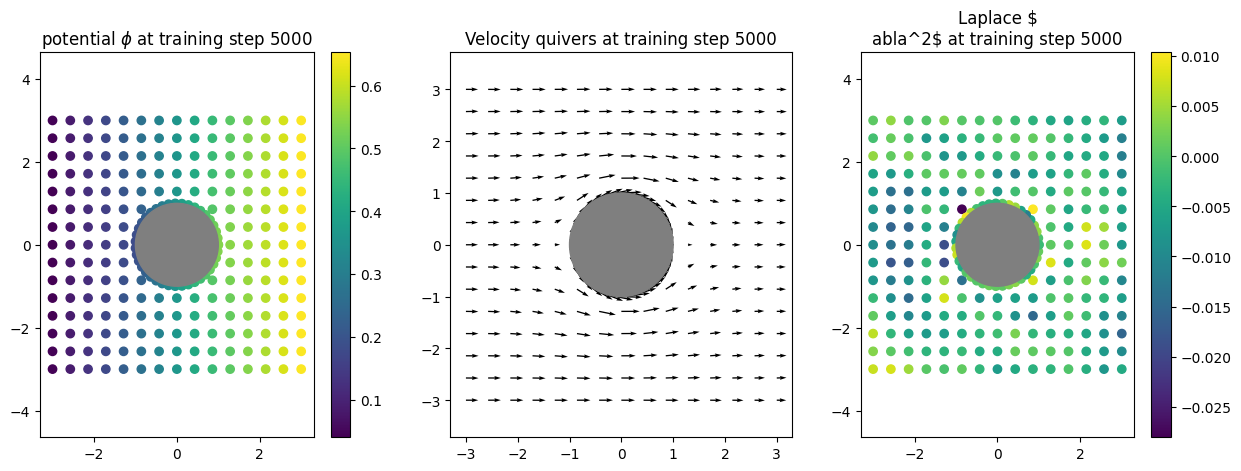

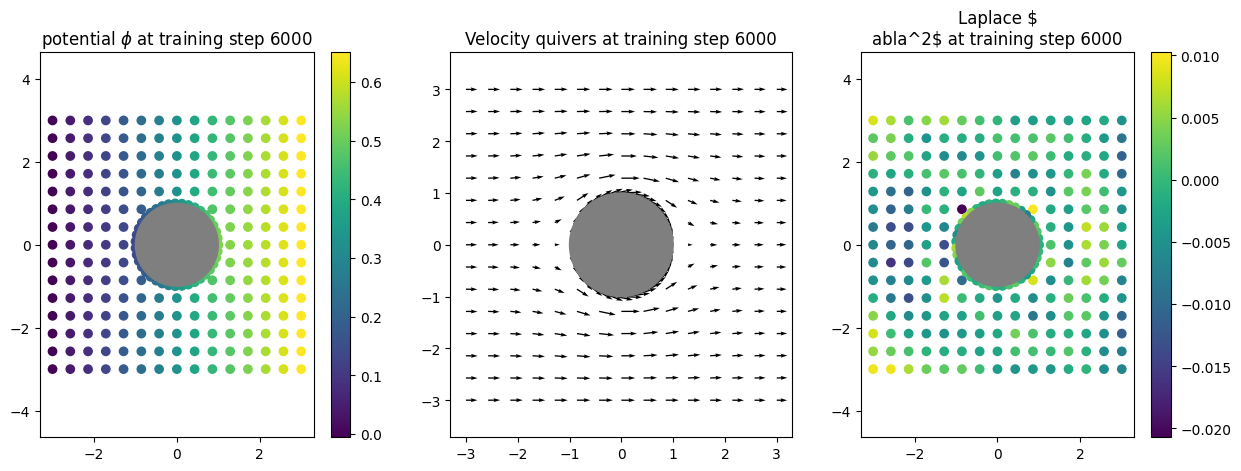

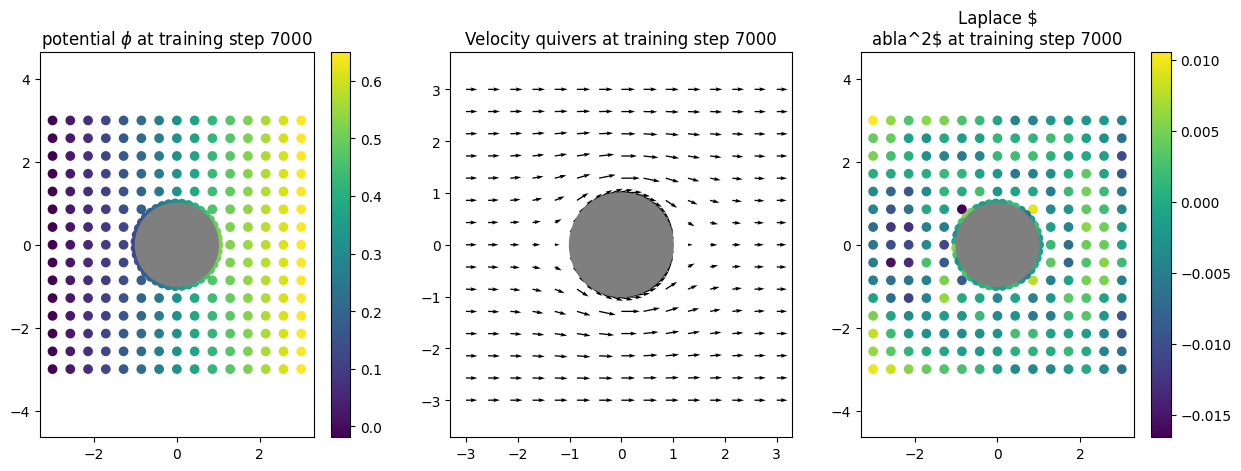

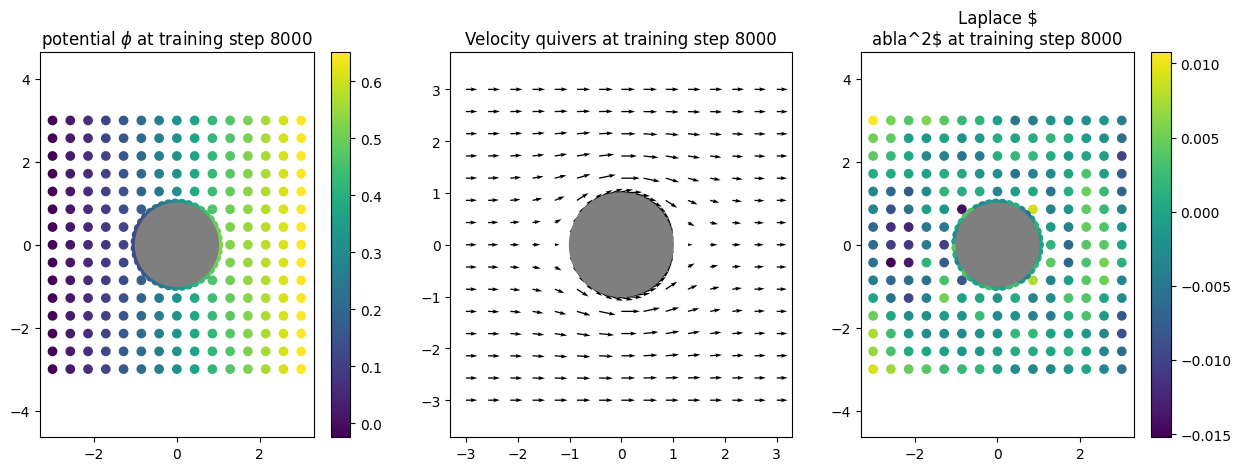

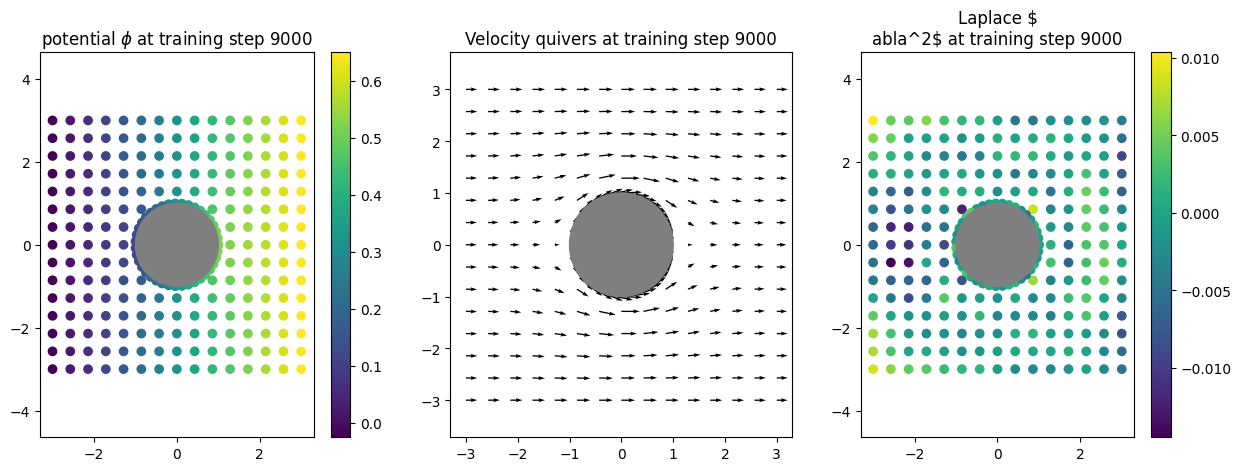

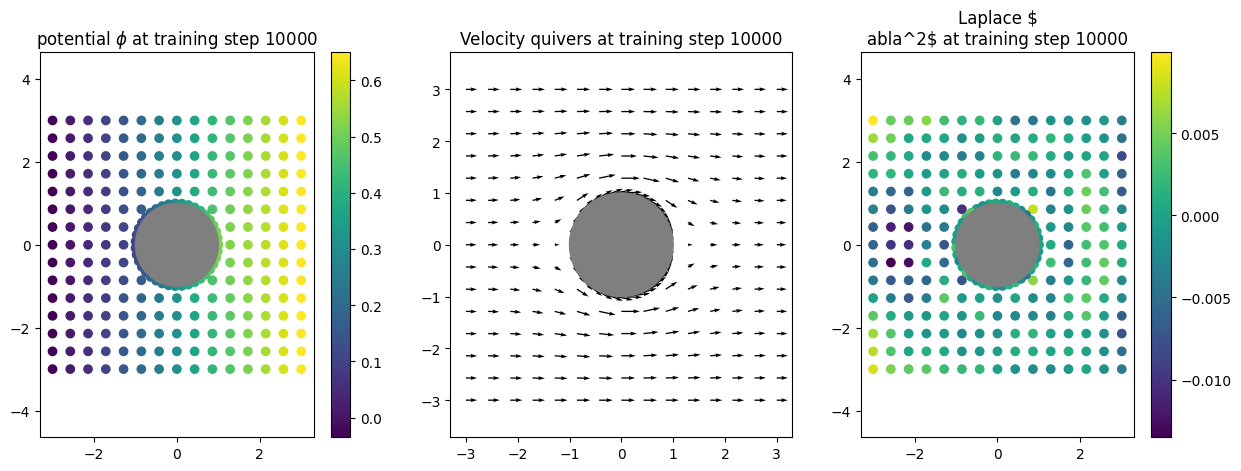

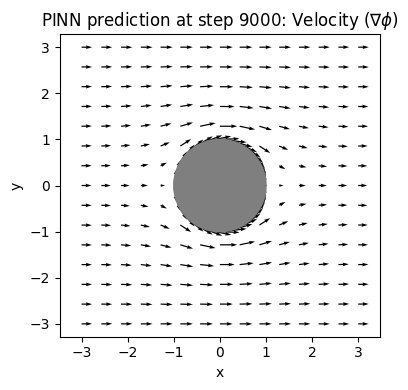

In [ ]:
torch.manual_seed(5)

pinn = FullyConnected(2, 32, 1)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

nr_steps = 10000

for i in range(nr_steps + 1):
  optimizer.zero_grad()

  phi = pinn(all_xys)

  grad_phi = torch.autograd.grad(phi, all_xys, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
  v_x = grad_phi[:, 0]
  v_y = grad_phi[:, 1]

  # Laplace PDE loss
  dvx_dx = torch.autograd.grad(v_x, all_xys, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0]
  dvy_dy = torch.autograd.grad(v_y, all_xys, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1]

  residual = dvx_dx + dvy_dy
  pde_loss = torch.mean(residual ** 2)

  # Inlet condition LHS vx = 0.1
  ideal_inlet_velocity_x = torch.ones(len(inlet_indices)) * 0.1
  ideal_inlet_velocity_y = torch.zeros(len(inlet_indices))

  residual_inlet_x = v_x[inlet_indices] - ideal_inlet_velocity_x
  residual_inlet_y = v_y[inlet_indices] - ideal_inlet_velocity_y

  inlet_loss = torch.mean(residual_inlet_x ** 2) + torch.mean(residual_inlet_y ** 2)

  # Outlet condition RHS phi = 1.0
  ideal_outlet_phi = torch.ones(len(outlet_indices)) * 0.65

  residual_outlet = phi[outlet_indices] - ideal_outlet_phi

  outlet_loss = torch.mean(residual_outlet ** 2)

  # No flux cylinder
  residual_cylinder = v_x[-1 * circle_points : ] * cylinder_normals[:, 0] + v_y[-1 * circle_points : ] * cylinder_normals[:, 1]
  cylinder_loss = torch.mean(residual_cylinder ** 2)

  # No flux lower wall
  residual_lower_wall = - v_y[lower_wall_indices] * torch.ones(len(lower_wall_indices))
  lower_wall_loss = torch.mean(residual_lower_wall ** 2)

  # No flux upper wall
  residual_upper_wall = v_y[upper_wall_indices] * torch.ones(len(upper_wall_indices))
  upper_wall_loss = torch.mean(residual_upper_wall ** 2)


  loss = pde_loss + inlet_loss + outlet_loss + cylinder_loss + lower_wall_loss + upper_wall_loss

  loss.backward()
  optimizer.step()

  if i % 1000 == 0 and i != 0:
    phi = pinn(all_xys).detach()
    grad_phi = grad_phi.detach().numpy()
    xys = all_xys.detach().numpy()
    laplace = residual.detach().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    circle1 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
    circle2 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
    circle3 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )

    m = ax1.scatter(xys[:, 0], xys[:, 1], c=phi)
    cbar = plt.colorbar(m, ax=ax1)
    ax1.axis("equal")
    ax1.add_patch(circle1)
    ax1.set_title(f"potential $\phi$ at training step {i}")

    m = ax2.quiver(xys[:, 0], xys[:, 1], grad_phi[:, 0], grad_phi[:, 1])
    ax2.axis("equal")
    ax2.add_patch(circle2)
    ax2.set_title(f"Velocity quivers at training step {i}")

    n = ax3.scatter(xys[:, 0], xys[:, 1], c=laplace)
    cbar = plt.colorbar(n, ax=ax3)
    ax3.axis("equal")
    ax3.add_patch(circle3)
    ax3.set_title(f"Laplace $\nabla^2$ at training step {i}")

    plt.show()

    if i == 10000:
      fig, ax2 = plt.subplots(figsize=(4, 4))
      ax2.quiver(xys[:, 0], xys[:, 1], grad_phi[:, 0], grad_phi[:, 1])
      ax2.set_title(r"PINN prediction at step 9000: Velocity ($\nabla \phi$)");
      circle4 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
      ax2.add_patch(circle4)
      ax2.set_xlabel('x')
      ax2.set_ylabel('y')
      ax2.axis('equal')

      plt.tight_layout()

      plt.show()




In [ ]:
def compute_analytical_solution(grid, U, R):
    """Applies analytical solution of cylinder flow to every point in the grid."""
    X, Y = grid
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    phi = U * r * (1 + R**2/r**2) * np.cos(theta) * (r > R)
    phi -= phi.min() # normalizing by minimum value
    v_r = U * (1 - R**2 / r**2) * np.cos(theta) * (r > R)
    v_theta = -U * (1 + R**2 / r**2) * np.sin(theta) * (r > R)
    v_x = np.cos(theta) * v_r - np.sin(theta) * v_theta
    v_y = np.sin(theta) * v_r + np.cos(theta) * v_theta

    return phi, v_x, v_y

def compute_gradient(grid, phi):
    """Numerically computes velocity as gradient of phi on grid."""
    X, Y = grid
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]
    v, u = np.gradient(phi, dx, dy)
    return u, v

def make_plot(phi_mapped, grid, uv=None):
    """Plots a solution to the potential flow on the grid."""
    fig, ax1 = plt.subplots(figsize=(4, 4))

    circle1 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )

    m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    # ax1.contour(grid[0], grid[1], phi_mapped, vmin=-1, vmax=16)
    plt.colorbar(m, ax=ax1)
    ax1.add_patch(circle1)
    ax1.axis('equal')
    ax1.set_title(r"Analytical solution: Potential $\phi$")
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    plt.tight_layout()

    plt.show()

    if uv is not None:
        u, v = uv
    else:
        u, v = compute_gradient(grid, phi_mapped)

    fig, ax2 = plt.subplots(figsize=(4, 4))

    circle2 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )

    ax2.quiver(grid[0], grid[1], u, v)
    ax2.set_title(r"Analytical solution: Velocity ($\nabla \phi$)");
    ax2.add_patch(circle2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.axis('equal')


    """
    ax3.streamplot(grid[0], grid[1], u, v)
    ax3.set_title('stream plot')
    ax3.axis('equal')
    """
    plt.tight_layout()

    plt.show()

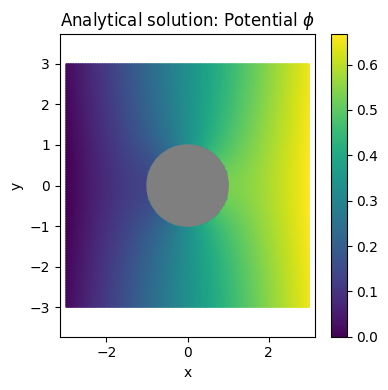

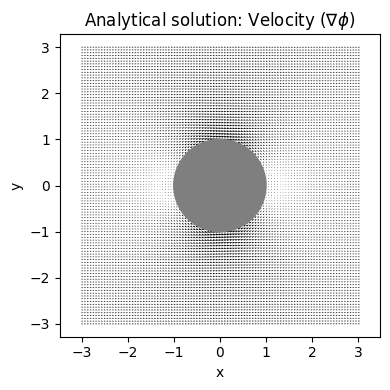

<ipython-input-69-f9474ee2bc8d>:6: RuntimeWarning: divide by zero encountered in divide
  phi = U * r * (1 + R**2/r**2) * np.cos(theta) * (r > R)
<ipython-input-69-f9474ee2bc8d>:6: RuntimeWarning: invalid value encountered in multiply
  phi = U * r * (1 + R**2/r**2) * np.cos(theta) * (r > R)
<ipython-input-69-f9474ee2bc8d>:8: RuntimeWarning: divide by zero encountered in divide
  v_r = U * (1 - R**2 / r**2) * np.cos(theta) * (r > R)
<ipython-input-69-f9474ee2bc8d>:8: RuntimeWarning: invalid value encountered in multiply
  v_r = U * (1 - R**2 / r**2) * np.cos(theta) * (r > R)
<ipython-input-69-f9474ee2bc8d>:9: RuntimeWarning: divide by zero encountered in divide
  v_theta = -U * (1 + R**2 / r**2) * np.sin(theta) * (r > R)
<ipython-input-69-f9474ee2bc8d>:9: RuntimeWarning: invalid value encountered in multiply
  v_theta = -U * (1 + R**2 / r**2) * np.sin(theta) * (r > R)


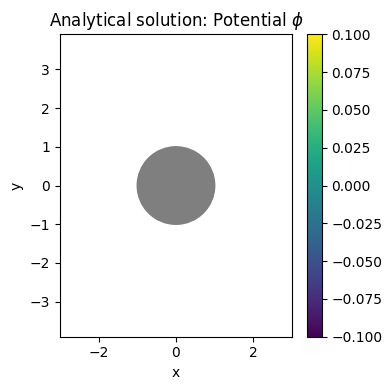

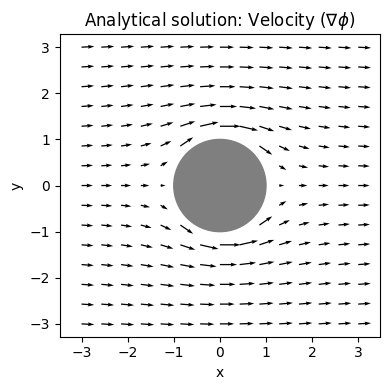

In [ ]:
full_grid = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

phi_exact, vx_exact, vy_exact = compute_analytical_solution(full_grid, 0.1, 1.0)

make_plot(phi_exact, full_grid, uv=(vx_exact, vy_exact))

small_grid = np.meshgrid(np.linspace(-3, 3, 15), np.linspace(-3, 3, 15))

phi_exact, vx_exact, vy_exact = compute_analytical_solution(small_grid, 0.1, 1.0)

make_plot(phi_exact, small_grid, uv=(vx_exact, vy_exact))

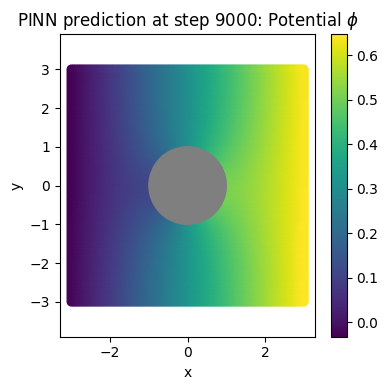

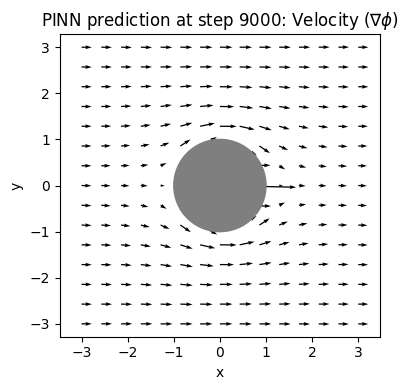

In [ ]:
fig, ax1 = plt.subplots(figsize=(4, 4))

full_grid_tensor = torch.stack((torch.tensor(full_grid[0], dtype=torch.float32).flatten(), torch.tensor(full_grid[1], dtype=torch.float32).flatten()), 1)

phi = pinn(full_grid_tensor).detach()
# grad_phi = grad_phi.detach().numpy()
xys = full_grid_tensor.detach().numpy()

m = ax1.scatter(xys[:, 0], xys[:, 1], c=phi)
# ax1.contour(np.reshape(xys[:, 0], (100, 100)), np.reshape(xys[:, 1], (100, 100)), np.reshape(phi, (100, 100)))
cbar = plt.colorbar(m, ax=ax1)
ax1.axis("equal")
circle3 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
ax1.add_patch(circle3)
ax1.set_title(r"PINN prediction at step 9000: Potential $\phi$")
# ax1.set_title(f"potential $\phi$ at training step {i}")
ax1.set_xlabel('x')
ax1.set_ylabel('y')

plt.tight_layout()

plt.show()

small_grid_tensor = torch.stack((torch.tensor(small_grid[0], dtype=torch.float32).flatten(), torch.tensor(small_grid[1], dtype=torch.float32).flatten()), 1).requires_grad_(True)

phi = pinn(small_grid_tensor)
grad_phi = torch.autograd.grad(phi, small_grid_tensor, grad_outputs=torch.ones_like(phi), create_graph=True)[0]
phi = phi.detach()
grad_phi = grad_phi.detach()
xys = small_grid_tensor.detach().numpy()

fig, ax2 = plt.subplots(figsize=(4, 4))
ax2.quiver(xys[:, 0], xys[:, 1], grad_phi[:, 0], grad_phi[:, 1])
ax2.set_title(r"PINN prediction at step 9000: Velocity ($\nabla \phi$)");
circle4 = plt.Circle(( 0 , 0 ), 1.0, color='tab:gray' )
ax2.add_patch(circle4)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.axis('equal')

plt.tight_layout()

plt.show()